In [1]:
import torch
#import albumentations
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision.transforms import Resize
import cv2
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
#from bayes_opt import BayesianOptimization
import pydicom
import matplotlib.pyplot as plt


I already have my data in a numpy format. Use dicom_helpers.py to convert DICOM files to numpy arrays.

In [2]:
images = np.load("/kaggle/input/hp-vs-ipf/HP_vs_IPF/images.npy")

labels = np.load("/kaggle/input/hp-vs-ipf/HP_vs_IPF/labels.npy")
print(images.shape, labels.shape)
images=images/255.0 
images=images.astype(np.float32)
images.dtype


(741, 512, 512) (741,)


dtype('float32')

In [3]:
class MyDataset(data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

Find Image Data Mean and Standard Deviation using the utils.py script, if required. Here, my images are already normalized.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    #transforms.Normalize(( 0.1545,), (0.1628,))
    ])
    
    



# Split the data into training, testing, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# Define the batch size, number of epochs, and learning rate
batch_size = 8

# Define the dataset and data loader for the training set
train_dataset = MyDataset(train_data, train_labels, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the dataset and data loader for the testing set
test_dataset = MyDataset(test_data, test_labels, transform=transform)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the dataset and data loader for the validation set
val_dataset = MyDataset(val_data, val_labels, transform=transform)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



Defining the model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 512)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
        x = x.view(-1, 512 * 8 * 8)
        x = self.drop1(self.fc1(x))
        x = self.fc2(x)
        return x

Defining the device to train the model on, the loss function, and optimization. Note the commented lines, those are an example of using an ensemble of schedulers.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.NAdam(net.parameters(), lr=0.001)
optimizer = optim.NAdam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
#scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

Training the model

100%|██████████| 19/19 [00:00<00:00, 55.17it/s]


[Epoch 1] Train Loss: 1.491, Val Loss: 15.365, Train Acc: 56 %, Val Acc: 45 %


100%|██████████| 19/19 [00:00<00:00, 52.40it/s]


[Epoch 2] Train Loss: 0.564, Val Loss: 24.616, Train Acc: 65 %, Val Acc: 54 %


100%|██████████| 19/19 [00:00<00:00, 55.43it/s]


[Epoch 3] Train Loss: 0.257, Val Loss: 2.975, Train Acc: 76 %, Val Acc: 74 %


100%|██████████| 19/19 [00:00<00:00, 55.05it/s]


[Epoch 4] Train Loss: 0.652, Val Loss: 0.832, Train Acc: 80 %, Val Acc: 89 %


100%|██████████| 19/19 [00:00<00:00, 41.33it/s]


[Epoch 5] Train Loss: 0.033, Val Loss: 1.476, Train Acc: 80 %, Val Acc: 84 %


100%|██████████| 19/19 [00:00<00:00, 55.73it/s]


[Epoch 6] Train Loss: 0.262, Val Loss: 1.176, Train Acc: 83 %, Val Acc: 85 %


100%|██████████| 19/19 [00:00<00:00, 47.19it/s]


[Epoch 7] Train Loss: 0.002, Val Loss: 0.258, Train Acc: 87 %, Val Acc: 93 %


100%|██████████| 19/19 [00:00<00:00, 55.74it/s]


[Epoch 8] Train Loss: 0.087, Val Loss: 0.117, Train Acc: 92 %, Val Acc: 95 %


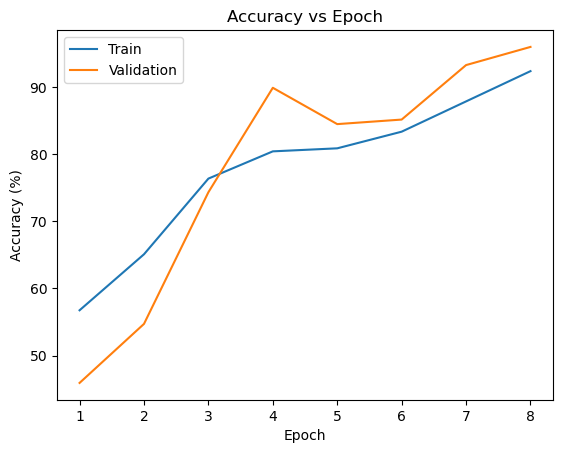

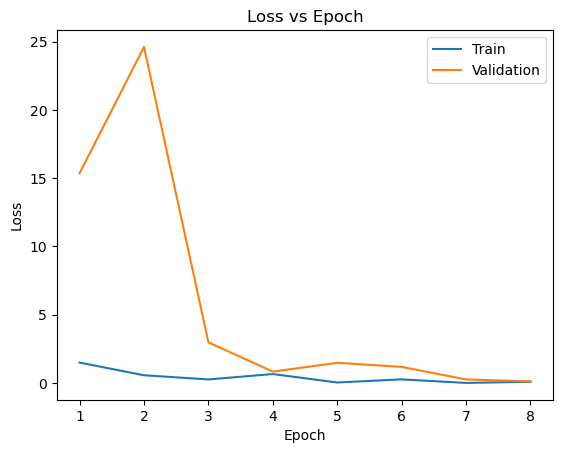

In [8]:
import matplotlib.pyplot as plt

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 3
counter = 0

# Initialize lists for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 8
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    net.train() # Set the network to training mode
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        
        
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).long()
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        
        outputs = net(inputs)
       # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:
            #print('[Epoch %d, Batch %d] Loss: %.3f' %
             #     (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the network on the validation set
    net.eval()  # Set the network to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(val_loader, total=len(val_loader)):
            images, labels = data
            images, labels = images.to(device), labels.to(device).long()
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print statistics
    train_loss = running_loss / len(train_loader)
    val_loss /= len(val_loader)
    #train_acc = 100 * correct / total
    val_acc = 100 * correct / total
    print('[Epoch %d] Train Loss: %.3f, Val Loss: %.3f, Train Acc: %d %%, Val Acc: %d %%' %
          (epoch + 1, train_loss, val_loss, train_acc, val_acc))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping after epoch ", epoch + 1)
            break

    # Update lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Update the learning rate scheduler
    #scheduler.step()
    #scheduler1.step()
    scheduler.step()

# Plot train and val acc vs epoch
plt.plot(range(1, epoch+2), train_accs, label="Train")
plt.plot(range(1, epoch+2), val_accs, label="Validation")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Plot train and val loss vs epoch
plt.plot(range(1, epoch+2), train_losses, label="Train")
plt.plot(range(1, epoch+2), val_losses, label="Validation")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Evaluating the model on unseen data

In [9]:
 net.eval()  # Set the network to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_loader, total=len(test_loader)):
        images, labels = data
        images, labels = images.to(device), labels.to(device).long()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

100%|██████████| 19/19 [00:00<00:00, 54.08it/s]

Accuracy on the test set: 93 %


Computing Classification Metrics

100%|██████████| 19/19 [00:00<00:00, 43.92it/s]


(149,) (149,)


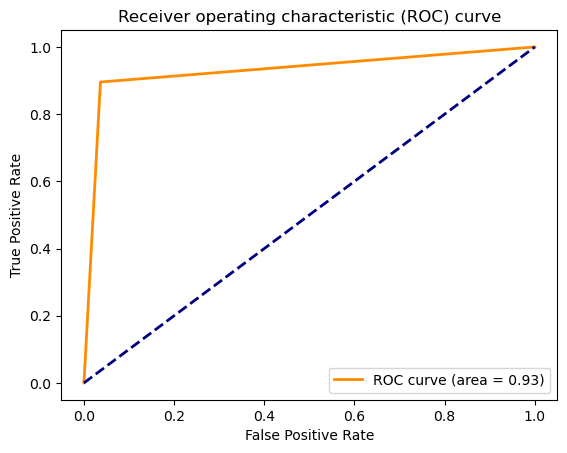

              precision    recall  f1-score   support

          HP       0.92      0.96      0.94        82
         IPF       0.95      0.90      0.92        67

    accuracy                           0.93       149
   macro avg       0.94      0.93      0.93       149
weighted avg       0.93      0.93      0.93       149



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

# Set the network to evaluation mode
net.eval()

y_true = []
y_score = []

with torch.no_grad():
    for data in tqdm(test_loader, total=len(test_loader)):
        images, labels = data
        images, labels = images.to(device), labels.to(device).long()
        outputs = net(images)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

# Calculate AUC
y_true=np.asarray(y_true)
y_score=np.asarray(y_score)
y_score=np.argmax(y_score, axis=1)
print(y_true.shape, y_score.shape)
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# Calculate classification report

target_names = ['HP', 'IPF']  # Replace with your class names
print(classification_report(y_true, y_score, target_names=target_names))